In [1]:
print("Shivaya Namah")

Shivaya Namah


### Human in the Loop

In [2]:
from pydantic_settings import  BaseSettings
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI
from langchain_groq.chat_models import ChatGroq

class Settings(BaseSettings): 

    pinecone_api_key: str 
    watsonx_apikey: str  
    watsonx_url: str
    watsonx_project_id: str
    cohere_api_key: str 
    tavily_api_key: str
    google_api_key: str
    groq_api_key: str



    class Config:
        env_file = ".env"
        extra = "ignore"

settings = Settings()
print("API keys loaded sucessfully.")

API keys loaded sucessfully.


In [3]:
llm = ChatGroq(
    groq_api_key = settings.groq_api_key,
    temperature = 0.7,
    max_retries = 2,
    max_tokens = 2000,
    model = "llama-3.1-8b-instant"
)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000025BBDB923C0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000025BBDB92F90>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'), max_tokens=2000)

In [4]:
llm = ChatGoogleGenerativeAI(
    google_api_key =  settings.google_api_key,
    model = "gemini-2.5-flash",
    max_tokens = 3000,
    temperature = 0.1
)
llm

ChatGoogleGenerativeAI(model='models/gemini-2.5-flash', google_api_key=SecretStr('**********'), temperature=0.1, max_output_tokens=3000, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x0000025BBDCDC440>, default_metadata=(), model_kwargs={})

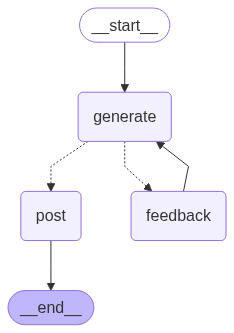

In [5]:
from langgraph.graph import END, StateGraph, add_messages
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from typing import Annotated, TypedDict, List

class ChatBotState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]


GENERATE = "generate"
POST = "post"
FEEDBACK = "feedback"

def generate_node(state: ChatBotState) -> ChatBotState:
    return {
        "messages": [llm.invoke(state["messages"])]
    }

def review_or_post(state: ChatBotState) -> ChatBotState:
    last_ai_message: AIMessage = state["messages"][-1]
    print(f"Current content:\n{last_ai_message.content}", end = "\n\n")

    print("Are you okay with a content, yes to put, no to provide feedback to improve.", end = "\n")
    human_input: str = input("yes/no")  
    
    if human_input.lower() == "yes":
        return POST
    return FEEDBACK


def feedback_node(state: ChatBotState) -> ChatBotState:
    print("Enter your feedback to improve the content.", end = "\n")

    feedback: str = input("Feedback: ")

    return {
        "messages": [
            HumanMessage(content = feedback)
        ]
    }


def post_node(state: ChatBotState) -> ChatBotState:
    print("The content posted sucessfully.")
    return state


graph_builder = StateGraph(ChatBotState)
graph_builder.add_node(GENERATE, generate_node)
graph_builder.add_node(POST, post_node)
graph_builder.add_node(FEEDBACK, feedback_node)
graph_builder.add_conditional_edges(
    GENERATE, 
    review_or_post,
    path_map = {
        FEEDBACK: FEEDBACK,
        POST: POST
    }
)
graph_builder.add_edge(FEEDBACK, GENERATE)
graph_builder.set_entry_point(GENERATE)
graph_builder.set_finish_point(POST)
graph = graph_builder.compile()

graph



In [6]:
response: ChatBotState = graph.invoke(
    ChatBotState(
        messages = [
            HumanMessage(
                content = "Write a LinkedIn blog in the topic of *AI Agents taking the job of content creation.*"
            )
        ]
    )
)

Current content:
## Are AI Agents Taking Over Content Creation? Here's What You Need to Know.

The whispers are growing louder, and for many content creators, they're tinged with a mix of fascination and fear: **Are AI agents coming for our jobs?**

With the rapid advancements in AI, particularly the emergence of autonomous AI agents capable of executing multi-step tasks, the question is no longer *if* AI will impact content creation, but *how profoundly*.

Let's cut through the hype and address the reality.

### The Rise of the Autonomous Content Agent

Gone are the days when AI was just a fancy spell-checker or a basic text generator. Today's AI agents, powered by sophisticated large language models, can:

*   **Conduct Research:** Scour the web for data, trends, and competitor insights.
*   **Outline & Draft:** Generate comprehensive content outlines and initial drafts for articles, social media posts, emails, and even video scripts.
*   **Optimize for SEO:** Integrate keywords, ana

### Using Interrupt method from LangGraph to implement Human in the Loop

Great question! The `Command` class in LangGraph is a powerful feature for **programmatic control flow** and **Human-in-the-Loop (HITL)** scenarios. Let me explain with real-world examples.

## What is the Command Class?

The `Command` class allows nodes to **control the graph execution flow** by specifying:
- Which node to go to next
- What to update in the state
- Whether to wait for human intervention

## Real-World Example: Customer Support Ticket System

Let me show you a practical HITL scenario where Commands are essential:## Key Benefits of Commands in HITL

**1. Dynamic Flow Control**
Instead of predefined edges, Commands let nodes decide the next step based on runtime conditions:
```python
# Traditional approach: fixed edges
graph.add_edge("categorize", "auto_resolve")  # Always goes here

# Command approach: dynamic routing
return Command(goto="human_review" if high_severity else "auto_resolve")
```

**2. State Updates + Navigation** 
Commands can simultaneously update state and control flow:
```python
return Command(
    update={"severity": "high", "escalation_needed": True},
    goto="human_review"
)
```

**3. Interrupt for Human Input**
The `interrupt()` function pauses execution until human intervention:
```python
return Command(goto=interrupt("human_approval"))
```

## Another Real-World Example: Content Moderation## Why Commands Are Powerful for HITL

**1. **Conditional Routing**: Based on AI confidence, severity, or business rules
**2. **Interrupt Points**: Pause for human input exactly when needed
**3. **State Management**: Update multiple state fields atomically
**4. **Dynamic Workflow**: Same graph handles different scenarios without hardcoded paths

## Traditional vs Command Approach

**Without Commands (Static)**:
```python
# Fixed edges - every ticket follows same path
graph.add_edge("categorize", "auto_resolve")
graph.add_edge("auto_resolve", "human_review")  # Always goes to human
```

**With Commands (Dynamic)**:
```python
# Dynamic routing based on business logic
if severity == "high":
    return Command(goto="human_review")  # Skip auto-resolution
else:
    return Command(goto="auto_resolve")  # Try automatic first
```

Commands make your HITL workflows **intelligent and efficient** by routing work to humans only when truly needed, while maintaining full control over the process flow.

# Human in the Loop without Interruption.

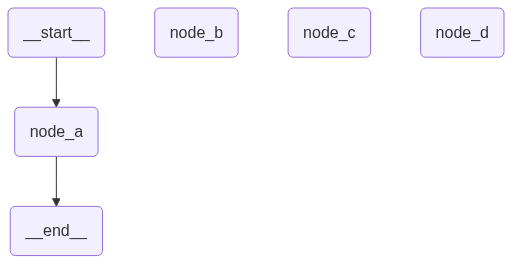

In [7]:
from langgraph.graph import StateGraph, END
from typing import Annotated, TypedDict, List
from langgraph.types import Command
import operator
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):
    path: Annotated[List[str], operator.concat]


NODE_A = "node_a" 
NODE_B = "node_b"
NODE_C = "node_c"
NODE_D = "node_d"

def node_a(state: State) -> State:
    print("Node A executed")
    return Command(
        goto = NODE_B,
        update = {
            "path": ["A"]
        } 
    )

def node_b(state: State) -> State:
    print("Node B executed")
    return Command(
        goto = NODE_C,
        update = {
            "path": ["B"]
        } 
    )

def node_c(state: State) -> State:
    print("Node C executed")
    return Command(
        goto = NODE_D,
        update = {
            "path": ["C"]
        } 
    )

def node_d(state: State) -> State:
    print("Node D executed")
    return Command(
        goto = END,
        update = {
            "path": ["D"]
        } 
    )

graph_builder = StateGraph(State)
graph_builder.add_node(NODE_A, node_a)
graph_builder.add_node(NODE_B, node_b)
graph_builder.add_node(NODE_C, node_c)
graph_builder.add_node(NODE_D, node_d)

graph_builder.set_entry_point(NODE_A)
# graph_builder.set_finish_point(NODE_D)

memory = InMemorySaver()

graph = graph_builder.compile(checkpointer = memory)
graph

In [8]:
response: State = graph.invoke(
    State(
        path = []
    ),
    config = {
        "configurable": {
            "thread_id": "my_thread"
        }
    }
)
response

Node A executed
Node B executed
Node C executed
Node D executed


{'path': ['A', 'B', 'C', 'D']}

# Human in the Loop with Interruption

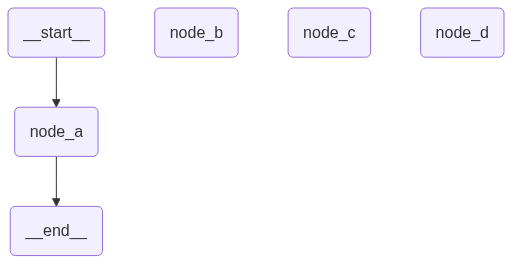

In [9]:
from langgraph.graph import StateGraph, END
from typing import Annotated, TypedDict, List
from langgraph.types import Command, interrupt
import operator
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):
    path: Annotated[List[str], operator.concat]


NODE_A = "node_a" 
NODE_B = "node_b"
NODE_C = "node_c"
NODE_D = "node_d"

def node_a(state: State) -> State:
    print("Node A executed")
    return Command(
        goto = NODE_B,
        update = {
            "path": ["A"]
        } 
    )

def node_b(state: State) -> State:
    print("Node B executed")

    human_review: str = interrupt("Where do you want to go C or D: ")

    if human_review.strip().lower() == "c":
        return Command(
            goto = NODE_C,
            update = {
                "path": ["B"]
            } 
        )
    return Command(
            goto = NODE_D,
            update = {
                "path": ["B"]
            } 
        )

def node_c(state: State) -> State:
    print("Node C executed")
    return Command(
        goto = NODE_D,
        update = {
            "path": ["C"]
        } 
    )

def node_d(state: State) -> State:
    print("Node D executed")
    return Command(
        goto = END,
        update = {
            "path": ["D"]
        } 
    )

graph_builder = StateGraph(State)
graph_builder.add_node(NODE_A, node_a)
graph_builder.add_node(NODE_B, node_b)
graph_builder.add_node(NODE_C, node_c)
graph_builder.add_node(NODE_D, node_d)

graph_builder.set_entry_point(NODE_A)
# graph_builder.set_finish_point(NODE_D)

memory = InMemorySaver()

graph = graph_builder.compile(checkpointer = memory)
graph

In [10]:
response: State = graph.invoke(
    State(
        path = []
    ),
    config = {
        "configurable": {
            "thread_id": "my_thread"
        }
    },
    stream_mode = "updates" 
)
response

Node A executed
Node B executed


[{'node_a': {'path': ['A']}},
 {'__interrupt__': (Interrupt(value='Where do you want to go C or D: ', resumable=True, ns=['node_b:4e04b7f2-405c-93f2-cc4d-437596de8d30']),)}]

In [11]:
print(graph.get_state(
    config = {
        "configurable": {
            "thread_id": "my_thread"
        }
    }
).next)

('node_b',)


## Invoke the graph again with a same config with a Command class.

In [12]:
second_response: State = graph.invoke(
    Command(
        resume = "D",
    ),
    config = {
        "configurable": {
            "thread_id": "my_thread"
        }
    },
    stream_mode = "updates"
)
second_response

Node B executed
Node D executed


[{'node_b': {'path': ['B']}}, {'node_d': {'path': ['D']}}]

In [13]:
second_response

[{'node_b': {'path': ['B']}}, {'node_d': {'path': ['D']}}]

## Human in the Loop for tool execution human review.

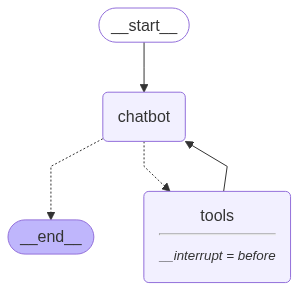

In [14]:
from langchain_tavily import TavilySearch
from pydantic import BaseModel, Field
from langchain_core.tools import tool, StructuredTool
from datetime import datetime
from langgraph.graph import END, StateGraph, add_messages
from typing import Annotated, TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import InMemorySaver


class InputSchema(BaseModel):
    """
    InputSchema defines the input structure for numerical operations, containing two fields:
    - num_1: The first number (integer or float).
    - num_2: The second number (integer or float).
    """
    num_1: int | float = Field(description = "The first number (integer or float) eg. 8 or 8.5")
    num_2: int | float = Field(description = "The second number (integer or float) eg. 8 or 8.5")


@tool(
    name_or_callable = "date_time", 
    description = "Use when you need to get current date and time.",
)
def get_current_date():
    """Returns the current Date."""
    return datetime.now().strftime("%Y-%m-%d %I:%M:%S, %p")


@tool(
    name_or_callable = "addition",
    description = "Use when you need to perform addition operation.",
    args_schema = InputSchema
)
def addition(num_1: int | float, num_2: int | float) -> float:
    """Returns the addition of two numbers."""
    return num_1 + num_2


@tool(
    name_or_callable = "multiplication",
    description = "Use when you need to perform multiplication operation.",
    args_schema = InputSchema
)
def multiplication(num_1: int | float, num_2: int | float) -> float:
    """Returns the multiplication of two numbers."""
    return num_1 * num_2



@tool(
    name_or_callable = "subtraction",
    description =  "Use when you need to perform subtraction operation.",
    args_schema = InputSchema
)
def subtraction(num_1: int | float, num_2: int | float) -> float:
    """Returns the subtraction of two numbers."""
    return num_1 - num_2


@tool(
    name_or_callable = "division",
    description = "Use when you need to perform division operation.",
    args_schema = InputSchema
)

def division(num_1: int | float, num_2: int | float) -> float:
    """Returns the division of two numbers."""
    if num_2 == 0:
        raise ValueError("Division by zero is not allowed.")
    return num_1 / num_2


tavily_search = TavilySearch(
    tavily_api_key = settings.tavily_api_key,
    max_results = 2
)

available_tools: List[StructuredTool | TavilySearch] = [
    addition, subtraction, multiplication, division, get_current_date, tavily_search
]



# Bind all the custom tools to the LLM.
llm_with_tools = llm.bind_tools(tools = available_tools)
# Create a ToolNode to execute appropriate tools.
tool_node: ToolNode = ToolNode(
    tools = available_tools,
    messages_key = "messages"
)

CHATBOT = "chatbot"
TOOLS = "tools"


class BasicChatBotState(TypedDict):
    "Represents the state of basic ChatBot"
    messages: Annotated[List[BaseMessage], add_messages]


def chatbot_node(state: BasicChatBotState) -> BasicChatBotState:
    """Execute tools and return the results."""
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }


def tool_call_required(state: BasicChatBotState) -> BasicChatBotState:
    """Check if the last message requires tool calls."""
    last_ai_message: AIMessage = state["messages"][-1]
    if last_ai_message.tool_calls:
        return TOOLS
    return END 


# Build the Graph Workflow.
graph_builder = StateGraph(BasicChatBotState)
graph_builder.add_node(CHATBOT, chatbot_node)
graph_builder.add_node(TOOLS, tool_node)
graph_builder.set_entry_point(CHATBOT)
graph_builder.add_edge(TOOLS, CHATBOT)
graph_builder.add_conditional_edges(
    CHATBOT,
    tool_call_required,
    path_map = {
        TOOLS: TOOLS,
        END: END
    }
)
graph_builder.add_edge(CHATBOT, END)

memory = InMemorySaver()

graph = graph_builder.compile(
    checkpointer = memory,
    interrupt_before = [TOOLS]
)

graph

In [15]:
config: dict = {
    "configurable": {
        "thread_id": 1
    }
}

In [16]:
events = graph.stream(
    BasicChatBotState(
        messages = [
            HumanMessage("Hi, this is Nagarjun.")
        ]
    ),
    config = config,
    stream_mode = "values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, this is Nagarjun.
================================== Ai Message ==================================

Hello Nagarjun! How can I help you today?


In [17]:
events = graph.stream(
    BasicChatBotState(
        messages = [
            HumanMessage("What is the weather in chennai today?")
        ]
    ),
    config = config,
    stream_mode = "values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the weather in chennai today?
================================== Ai Message ==================================

I am sorry, I cannot provide real-time weather updates. Is there anything else I can help with?


### Here the tool node is exited and waiting for our approval. Since we don't have any variables we just pass **None** to resume the Graph.

In [18]:
events = graph.stream(
    None,
    config = config,
    stream_mode = "values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

I am sorry, I cannot provide real-time weather updates. Is there anything else I can help with?


In [19]:
response: BasicChatBotState = graph.invoke(
    BasicChatBotState(
        messages = [
            HumanMessage("what is my last question and your answer?")
        ]
    ),
    config = config
)
response

{'messages': [HumanMessage(content='Hi, this is Nagarjun.', additional_kwargs={}, response_metadata={}, id='581aff9b-73a8-4895-bb4b-df99e1ffb808'),
  AIMessage(content='Hello Nagarjun! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--d4789f9f-d5c7-4adc-8045-d1d7b0390d1c-0', usage_metadata={'input_tokens': 1639, 'output_tokens': 11, 'total_tokens': 1650, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='What is the weather in chennai today?', additional_kwargs={}, response_metadata={}, id='4c9aba53-0c0e-4fc4-9da1-fc74d7befe61'),
  AIMessage(content='I am sorry, I cannot provide real-time weather updates. Is there anything else I can help with?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-fl